In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import networkx as nx
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GINConv
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import random
import itertools

C:\Users\0\AppData\Local\Temp\ipykernel_27724\1469433929.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.centroid


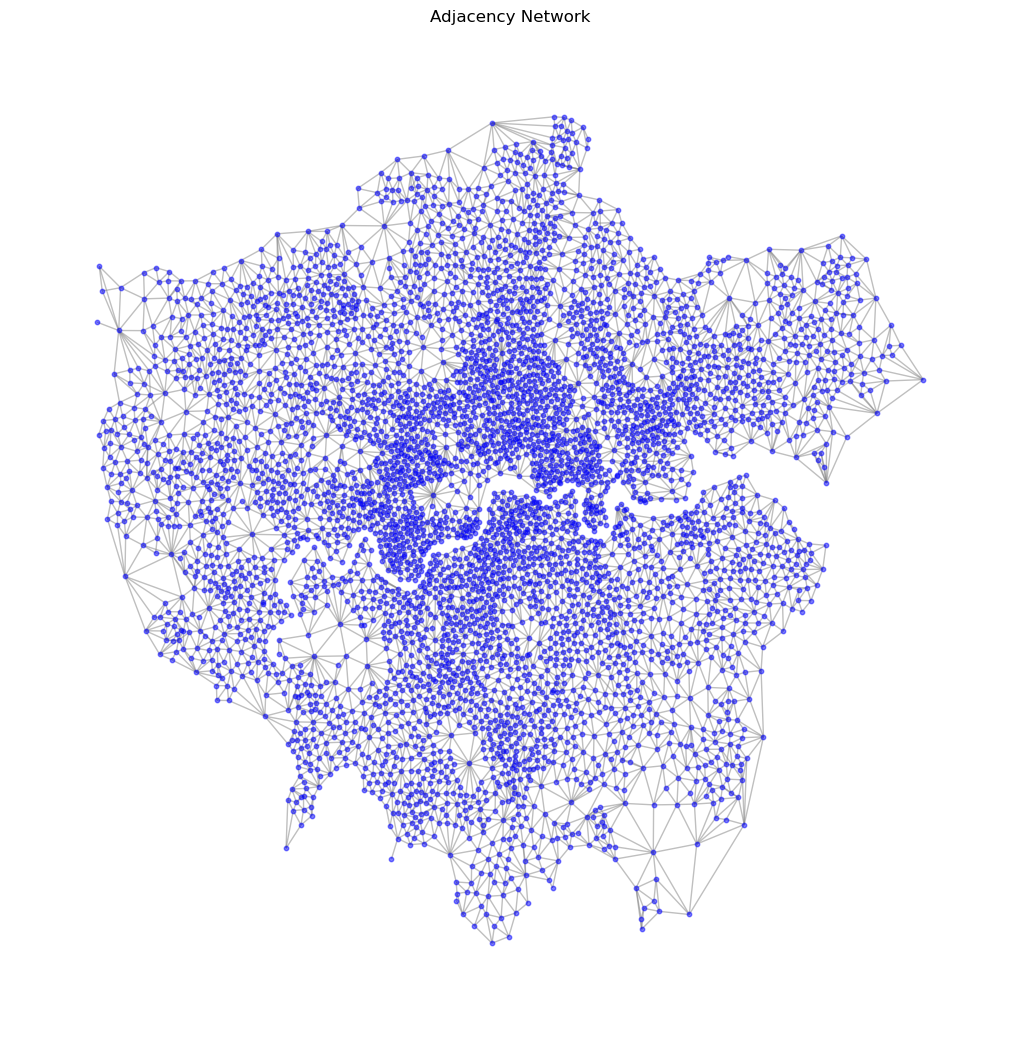

In [20]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
edges_added = set()
for idx, row in neighbors.iterrows():
    if row.name != row['index_right']:  # 避免自环
        edge = tuple(sorted((row.name, row['index_right'])))
        if edge not in edges_added:
            G.add_edge(row.name, row['index_right'], weight=1)
            edges_added.add(edge)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

# 提取节点特征
node_features = gdf[['e_ndvi', 'e_water', 'e_trees', 'e_grass', 'e_bare','e_built','e_shrub_and_scrub','e_crops','e_flooded_vegetation']].apply(pd.to_numeric, errors='coerce')

# 标准化节点特征
scaler = StandardScaler()
node_features_scaled = scaler.fit_transform(node_features)
node_features_tensor = torch.tensor(node_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_depression_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float)

# 计算边的属性（绝对差值）
edge_attributes = []
edges = []
for u, v in G.edges():
    edge_weight = abs(targets[u].item() - targets[v].item())
    edge_attributes.append(edge_weight)
    edges.append((u, v))

# 转换为PyTorch Geometric数据
data = from_networkx(G)
data.x = node_features_tensor
data.edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
data.edge_attr = torch.tensor(edge_attributes, dtype=torch.float).unsqueeze(1)  # 添加维度以匹配模型输入
data.y = torch.tensor(edge_attributes, dtype=torch.float).unsqueeze(1)

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GINConv
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import random
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数，加入Early Stopping和学习率调度器
def train(model, optimizer, data, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True)
    
    for epoch in range(1, 201):
        optimizer.zero_grad()
        out = model(data)
        edge_index = data.edge_index
        pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])
        loss = F.mse_loss(pred_edge_attr, data.edge_attr)
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return best_loss

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    print(f"Testing parameters: {params}")
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # out_channels should be 1 for regression
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    loss = train(model, optimizer, data)
    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # out_channels should be 1 for regression
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
best_loss = float('inf')
patience_counter = 0
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True)

for epoch in range(best_params['num_epochs']):
    optimizer.zero_grad()
    out = model(data)
    edge_index = data.edge_index
    pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])
    loss = F.mse_loss(pred_edge_attr, data.edge_attr)
    loss.backward()
    optimizer.step()
    
    scheduler.step(loss)

    if loss < best_loss:
        best_loss = loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter > 10:  # Early stopping patience
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
    losses.append(loss.item())

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    out = model(data)
    edge_index = data.edge_index
    pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])

# 计算评估指标
y_true = data.edge_attr.detach().numpy().flatten()
y_pred = pred_edge_attr.detach().numpy().flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
residuals = y_true - y_pred
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


C:\Users\0\AppData\Local\Temp\ipykernel_27724\3797827679.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.centroid


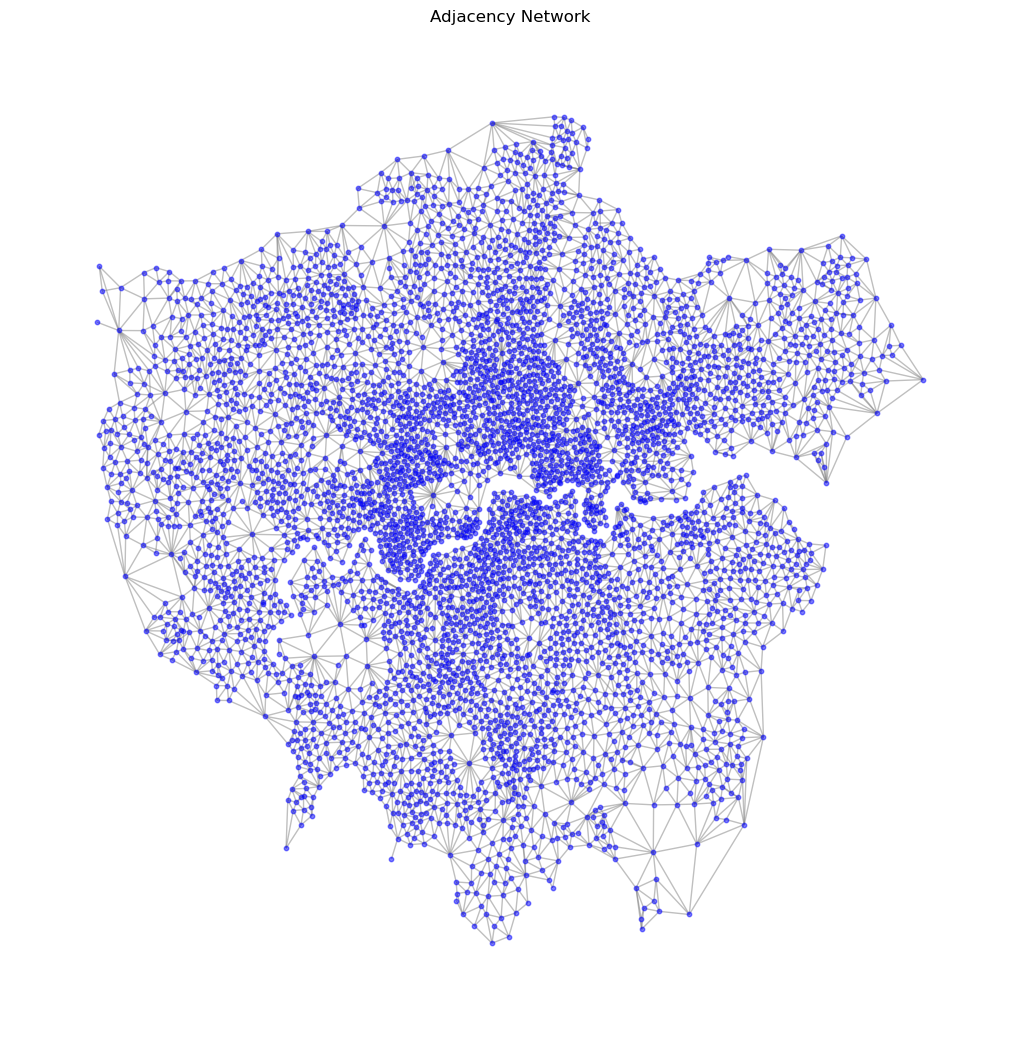

Remaining NaN count per column after filling:
 e_ndvi                  0
e_water                 0
e_trees                 0
e_grass                 0
e_bare                  0
e_built                 0
e_shrub_and_scrub       0
e_crops                 0
e_flooded_vegetation    0
dtype: int64


In [21]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GINConv
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import random
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau
import networkx as nx
import geopandas as gpd
from shapely import wkt
import pandas as pd
from torch_geometric.utils import from_networkx
import re

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
edges_added = set()
for idx, row in neighbors.iterrows():
    if row.name != row['index_right']:  # 避免自环
        edge = tuple(sorted((row.name, row['index_right'])))
        if edge not in edges_added:
            G.add_edge(row.name, row['index_right'], weight=1)
            edges_added.add(edge)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

# 提取节点特征
node_features = gdf[['e_ndvi', 'e_water', 'e_trees', 'e_grass', 'e_bare','e_built','e_shrub_and_scrub','e_crops','e_flooded_vegetation']].apply(pd.to_numeric, errors='coerce')

# excluded_e_columns = ['e_ozone', 'e_total_aerosol_optical_depth_at_550nm_surface', 'e_particulate_matter_d_less_than_25_um_surface']
# e_features_columns = [col for col in gdf.columns if col.startswith('e_'|'c_') and col not in excluded_e_columns]

# 排除特定列
# excluded_columns = ['e_ozone', 'e_total_aerosol_optical_depth_at_550nm_surface', 'e_particulate_matter_d_less_than_25_um_surface']
# 使用正则表达式选择以 e_ 和 c_ 开头的列，并排除特定的列
# selected_columns = [col for col in gdf.columns if (col.startswith('e_') or col.startswith('c_')) and col not in excluded_columns]


# node_features = gdf[selected_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in node_features.iterrows():
    for col in node_features.columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))  # 使用NetworkX图获取邻居索引
            if neighbor_indices:  # 确保有邻居
                neighbor_values = node_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = node_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                node_features.at[i, col] = mean_value
            else:
                node_features.at[i, col] = node_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count per column after filling:\n", node_features.isna().sum())

# 标准化节点特征
scaler = StandardScaler()
node_features_scaled = scaler.fit_transform(node_features)
node_features_tensor = torch.tensor(node_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_depression_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float)

# 计算边的属性（绝对差值）
edge_attributes = []
edges = []
for u, v in G.edges():
    edge_weight = abs(targets[u].item() - targets[v].item())
    edge_attributes.append(edge_weight)
    edges.append((u, v))

# 转换为PyTorch Geometric数据
data = from_networkx(G)
data.x = node_features_tensor
data.edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
data.edge_attr = torch.tensor(edge_attributes, dtype=torch.float).view(-1, 1)
data.y = torch.tensor(edge_attributes, dtype=torch.float).view(-1, 1)

Best params: {'lr': 0.01, 'weight_decay': 0.001, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 36.3322
MSE: 33.1352
RMSE: 5.7563
MAE: 3.7050
R²: 0.3155


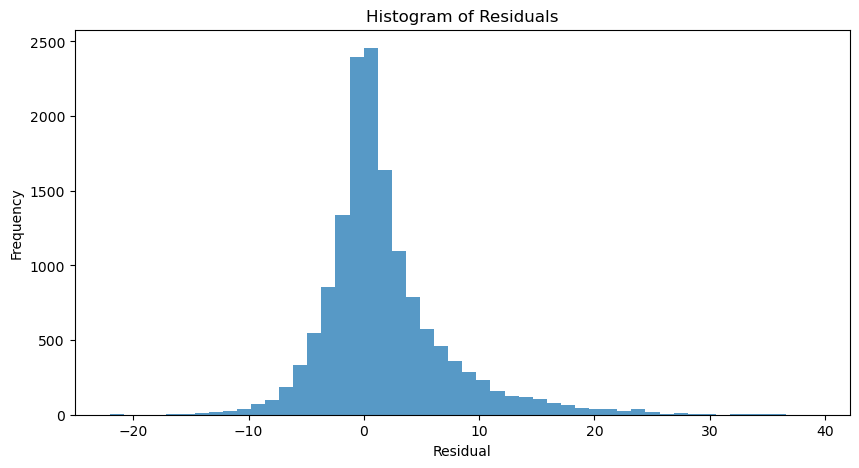

In [9]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    edge_index = data.edge_index
    pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])
    loss = F.mse_loss(pred_edge_attr, data.edge_attr)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # out_channels should be 1 for regression
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # out_channels should be 1 for regression
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    out = model(data)
    edge_index = data.edge_index
    pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])

# 计算评估指标
y_true = data.edge_attr.detach().numpy().flatten()
y_pred = pred_edge_attr.detach().numpy().flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
residuals = y_true - y_pred
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

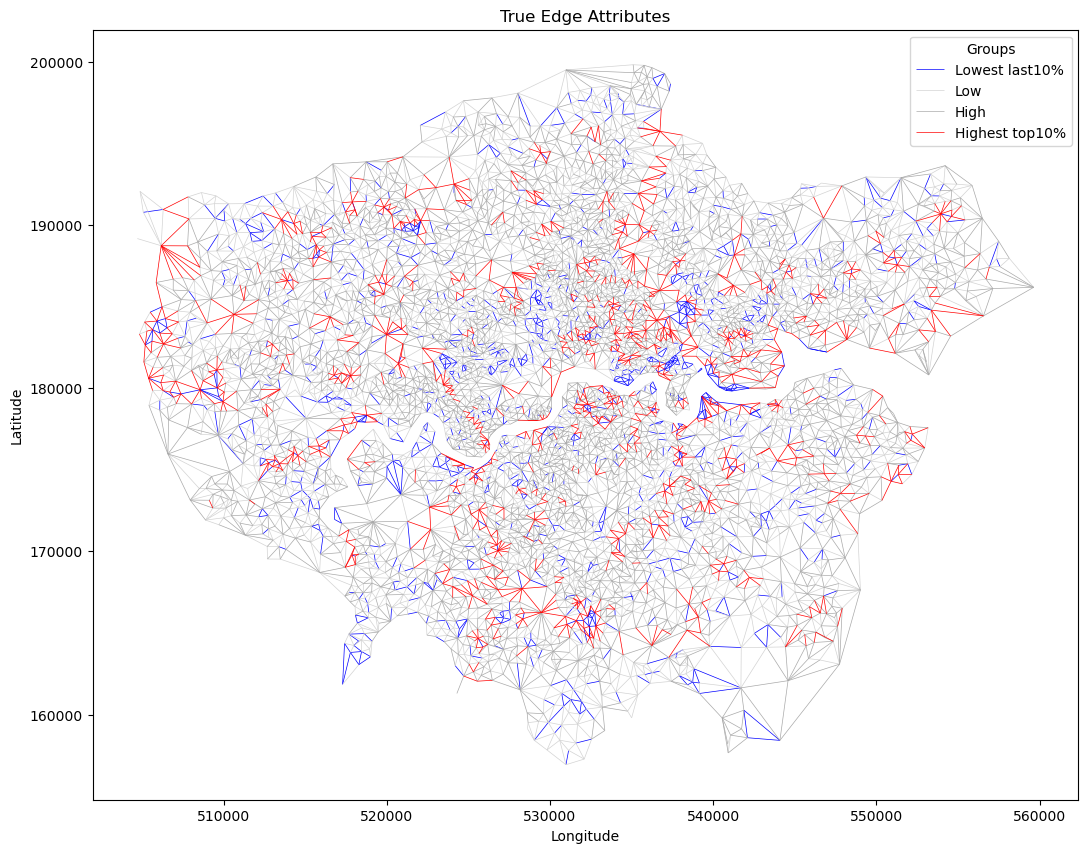

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString
import numpy as np
import pandas as pd

# 获取边的坐标
edge_lines = []
for u, v in G.edges():
    u_pos = G.nodes[u]['pos']
    v_pos = G.nodes[v]['pos']
    line = LineString([u_pos, v_pos])
    edge_lines.append(line)

# 创建 GeoDataFrame 保存边的几何信息
edge_gdf = gpd.GeoDataFrame(geometry=edge_lines)

# 将真实值添加到 GeoDataFrame 中
edge_gdf['true'] = y_true

# 将真实值分为四组
quantiles = np.quantile(edge_gdf['true'], [0, 0.1, 0.5, 0.90, 1.0])
colors = ['blue', 'lightgray', 'darkgray', 'red']
edge_gdf['color'] = pd.cut(edge_gdf['true'], bins=quantiles, labels=colors, include_lowest=True)

# 绘制地图
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# 根据颜色分组绘制边
for color in colors:
    edge_gdf[edge_gdf['color'] == color].plot(ax=ax, color=color, linewidth=0.5, label=f'{color} group')

# 添加图例
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], ['Lowest last10%', 'Low', 'High', 'Highest top10%'], title='Groups')

ax.set_aspect('equal')  # 确保长宽比相等
plt.title("True Edge Attributes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


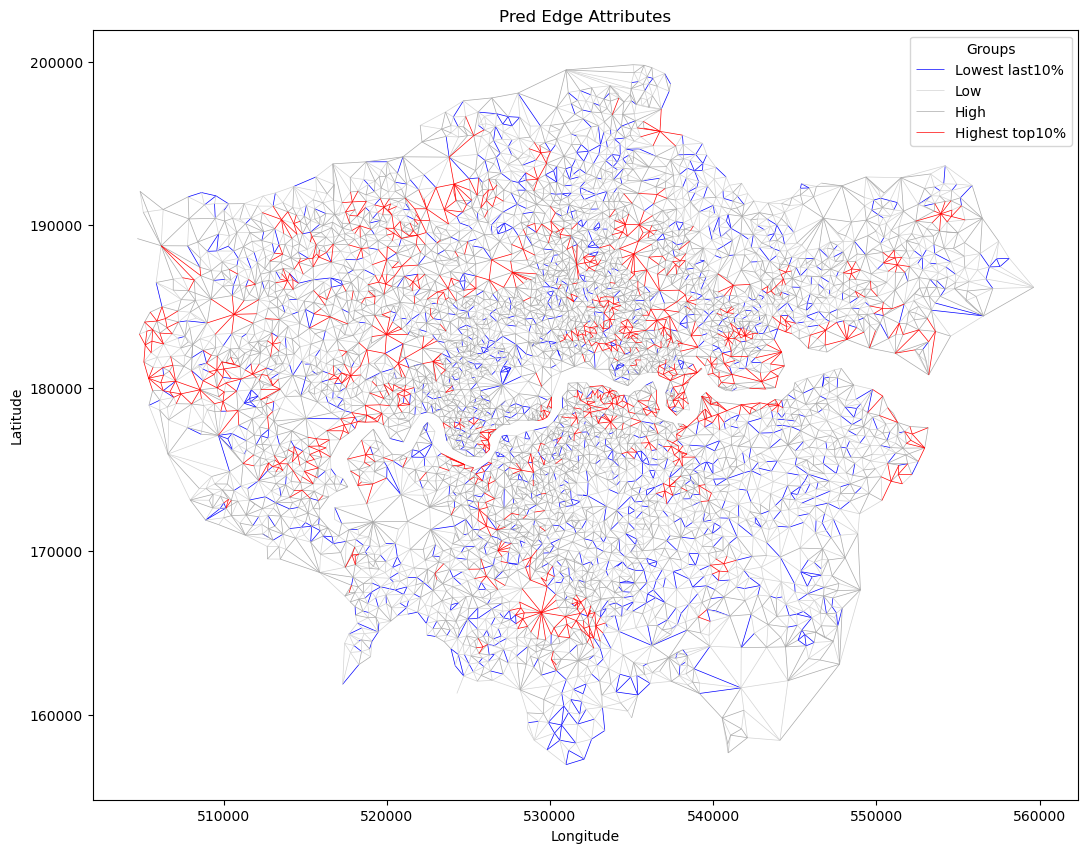

In [18]:
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString
import numpy as np
import pandas as pd

# 获取边的坐标
edge_lines = []
for u, v in G.edges():
    u_pos = G.nodes[u]['pos']
    v_pos = G.nodes[v]['pos']
    line = LineString([u_pos, v_pos])
    edge_lines.append(line)

# 创建 GeoDataFrame 保存边的几何信息
edge_gdf = gpd.GeoDataFrame(geometry=edge_lines)

# 将真实值添加到 GeoDataFrame 中
edge_gdf['true'] = y_pred

# 将真实值分为四组
quantiles = np.quantile(edge_gdf['true'], [0, 0.1, 0.5, 0.90, 1.0])
colors = ['blue', 'lightgray', 'darkgray', 'red']
edge_gdf['color'] = pd.cut(edge_gdf['true'], bins=quantiles, labels=colors, include_lowest=True)

# 绘制地图
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# 根据颜色分组绘制边
for color in colors:
    edge_gdf[edge_gdf['color'] == color].plot(ax=ax, color=color, linewidth=0.5, label=f'{color} group')

# 添加图例
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], ['Lowest last10%', 'Low', 'High', 'Highest top10%'], title='Groups')

ax.set_aspect('equal')  # 确保长宽比相等
plt.title("Pred Edge Attributes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


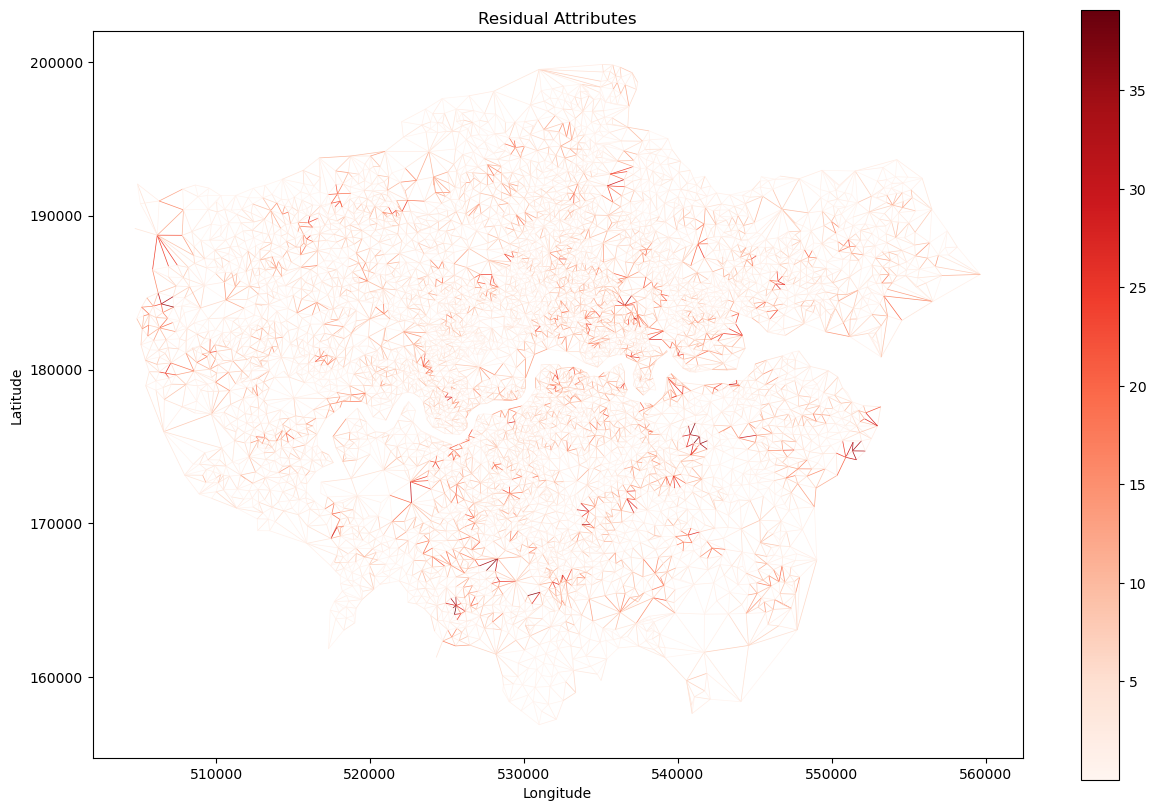

In [17]:
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString

# 获取边的坐标
edge_lines = []
for u, v in G.edges():
    u_pos = G.nodes[u]['pos']
    v_pos = G.nodes[v]['pos']
    line = LineString([u_pos, v_pos])
    edge_lines.append(line)

# 创建 GeoDataFrame 保存边的几何信息
edge_gdf = gpd.GeoDataFrame(geometry=edge_lines)

# 将真实值添加到 GeoDataFrame 中
edge_gdf['true'] = abs(y_true - y_pred)

# 绘制地图
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# 根据真实值绘制边的颜色
edge_gdf.plot(ax=ax, column='true', cmap='Reds', linewidth=0.5, legend=True)
ax.set_aspect('equal')  # 确保长宽比相等

plt.title("Residual Attributes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Starting random search over hyperparameters...

Training with parameter set 1/100: {'lr': 0.005, 'weight_decay': 0.0005, 'hidden1': 128, 'hidden2': 32, 'dropout': 0.7, 'num_epochs': 100}
Epoch 10/100, Loss: 59.8530
Epoch 20/100, Loss: 59.0051
Epoch 30/100, Loss: 58.3054
Epoch 40/100, Loss: 58.1260
Epoch 50/100, Loss: 56.9062
Epoch 60/100, Loss: 57.5656
Epoch 70/100, Loss: 56.2055
Epoch 80/100, Loss: 56.3180
Epoch 90/100, Loss: 56.5558
Epoch 100/100, Loss: 56.1576
Final loss for this parameter set: 56.1576

Training with parameter set 2/100: {'lr': 0.001, 'weight_decay': 0.001, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.5, 'num_epochs': 200}
Epoch 10/200, Loss: 71.1684
Epoch 20/200, Loss: 68.6723
Epoch 30/200, Loss: 65.1820
Epoch 40/200, Loss: 62.6558
Epoch 50/200, Loss: 60.8771
Epoch 60/200, Loss: 60.8720
Epoch 70/200, Loss: 58.9686
Epoch 80/200, Loss: 58.7592
Epoch 90/200, Loss: 58.4678
Epoch 100/200, Loss: 58.7652
Epoch 110/200, Loss: 58.6674
Epoch 120/200, Loss: 57.5615
Epoch 130/20

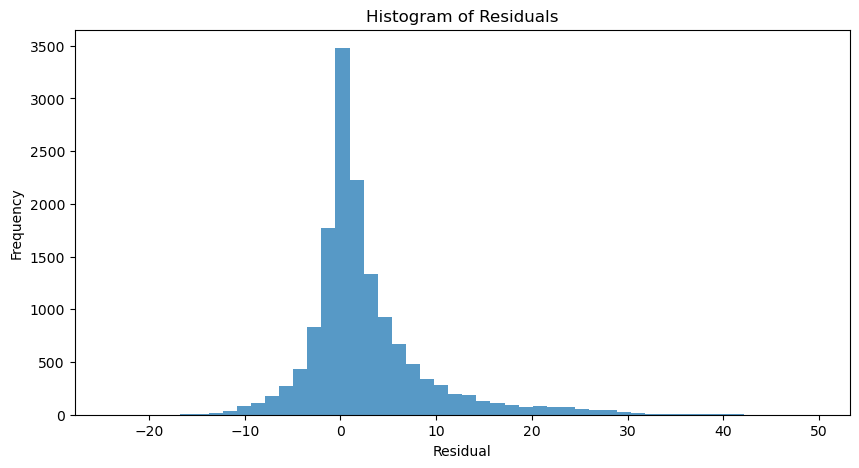

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import random
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1)
        self.conv2 = GATv2Conv(hidden1, hidden2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    edge_index = data.edge_index
    pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])
    loss = F.mse_loss(pred_edge_attr, data.edge_attr)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 100
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

print("Starting random search over hyperparameters...")

for i, params in enumerate(random_params):
    print(f"\nTraining with parameter set {i+1}/{num_samples}: {params}")
    model = GATv2(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # out_channels should be 1 for regression
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        if (epoch + 1) % 10 == 0 or epoch == params['num_epochs'] - 1:
            print(f"Epoch {epoch+1}/{params['num_epochs']}, Loss: {loss:.4f}")
        losses.append(loss)

    final_loss = losses[-1]
    print(f"Final loss for this parameter set: {final_loss:.4f}")
    
    if final_loss < best_loss:
        best_loss = final_loss
        best_params = params

print(f'\nBest params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
print("\nRe-training with the best hyperparameters...")
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # out_channels should be 1 for regression
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    if (epoch + 1) % 10 == 0 or epoch == best_params['num_epochs'] - 1:
        print(f"Epoch {epoch+1}/{best_params['num_epochs']}, Loss: {loss:.4f}")
    losses.append(loss)

# 测试模型并计算评估指标
print("\nEvaluating the model...")
model.eval()
with torch.no_grad():
    out = model(data)
    edge_index = data.edge_index
    pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])

# 计算评估指标
y_true = data.edge_attr.detach().numpy().flatten()
y_pred = pred_edge_attr.detach().numpy().flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'\nEvaluation Metrics:')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
print("\nVisualizing residuals...")
residuals = y_true - y_pred
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


# 地理编码

In [22]:
data

Data(edge_index=[2, 14736], pos=[4994, 2], weight=[29472], x=[4994, 9], edge_attr=[14736, 1], y=[14736, 1])

In [23]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GINConv
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import random
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau
import networkx as nx
import geopandas as gpd
from shapely import wkt
import pandas as pd
from torch_geometric.utils import from_networkx, to_networkx
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
# 手动计算拉普拉斯特征
def compute_laplacian_pe(edge_index, num_nodes, pe_dim):
    edge_index = edge_index.numpy()
    num_edges = edge_index.shape[1]

    # 创建稀疏邻接矩阵
    adj = sp.coo_matrix((np.ones(num_edges), (edge_index[0], edge_index[1])), shape=(num_nodes, num_nodes))

    # 计算度矩阵
    degree = np.array(adj.sum(axis=1)).flatten()
    degree_inv_sqrt = np.power(degree, -0.5)
    degree_inv_sqrt[np.isinf(degree_inv_sqrt)] = 0
    D_inv_sqrt = sp.diags(degree_inv_sqrt)

    # 计算标准化拉普拉斯矩阵
    L = sp.eye(num_nodes) - D_inv_sqrt @ adj @ D_inv_sqrt

    # 计算拉普拉斯特征
    eigval, eigvec = eigsh(L, k=pe_dim, which='SM')
    return torch.from_numpy(eigvec).float()

# 计算拉普拉斯位置编码并添加到节点特征中
pe_dim = 20
laplace_pe = compute_laplacian_pe(data.edge_index, data.num_nodes, pe_dim)
data.x = torch.cat([data.x, laplace_pe], dim=1)

C:\Users\0\AppData\Local\Temp\ipykernel_27724\3621348263.py:31: RuntimeWarning: divide by zero encountered in power
  degree_inv_sqrt = np.power(degree, -0.5)


In [24]:
laplace_pe

tensor([[-1.9690e-04,  1.9001e-04, -1.9956e-04,  ...,  7.0768e-04,
         -5.1504e-03, -1.9454e-03],
        [-1.0105e-02,  2.2905e-04, -4.8608e-03,  ...,  2.3924e-03,
          2.3114e-03, -1.1359e-03],
        [-1.2551e-02,  1.7305e-04, -5.7699e-03,  ...,  1.5935e-03,
          4.3576e-03,  4.5422e-04],
        ...,
        [ 4.1866e-03, -5.2362e-05,  2.1441e-03,  ...,  3.4851e-04,
          1.0843e-04, -1.1997e-03],
        [ 7.6027e-04, -9.5086e-06,  3.8936e-04,  ...,  6.3288e-05,
          1.9690e-05, -2.1786e-04],
        [ 4.7144e-03, -5.8962e-05,  2.4144e-03,  ...,  3.9245e-04,
          1.2210e-04, -1.3509e-03]])

Best params: {'lr': 0.005, 'weight_decay': 0.0005, 'hidden1': 128, 'hidden2': 64, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 13.7418

Evaluating the model...

Evaluation Metrics:
MSE: 11.5075
RMSE: 3.3923
MAE: 2.2617
R²: 0.4646

Visualizing residuals...


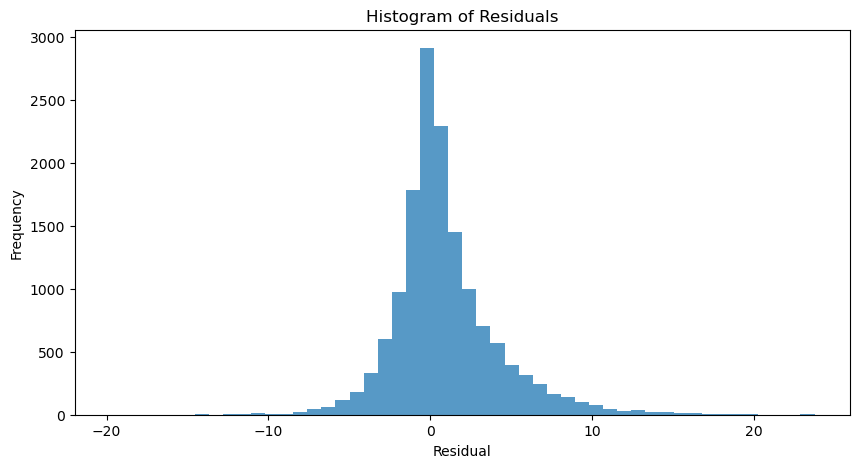

In [26]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    edge_index = data.edge_index
    pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])
    loss = F.mse_loss(pred_edge_attr, data.edge_attr)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 40
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=1,  # out_channels should be 1 for regression
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=1,  # out_channels should be 1 for regression
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
print("\nEvaluating the model...")
model.eval()
with torch.no_grad():
    out = model(data)
    edge_index = data.edge_index
    pred_edge_attr = torch.abs(out[edge_index[0]] - out[edge_index[1]])

# 计算评估指标
y_true = data.edge_attr.detach().numpy().flatten()
y_pred = pred_edge_attr.detach().numpy().flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'\nEvaluation Metrics:')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
print("\nVisualizing residuals...")
residuals = y_true - y_pred
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()
